### **Library Imports**

In [1]:
import os
import re
import cv2
import torch
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms

from sklearn.model_selection import KFold

### **Utilities and Constants**

In [2]:
SEED = 42
SIZE = 224


def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")
    
    
def get_image(path: str) -> np.ndarray:
    return cv2.resize(src=cv2.cvtColor(src=cv2.imread(path, cv2.IMREAD_COLOR), code=cv2.COLOR_BGR2RGB), dsize=(SIZE, SIZE), interpolation=cv2.INTER_AREA)


def show_loss_graph(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.show()

    
def show_lr_graph(LR: list) -> None:
    x_Axis = [i+1 for i in range(len(LR))]
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, LR, "rx")
    plt.grid()
    plt.show()

    
    
def show(image: np.ndarray, cmap: str="gnuplot2") -> None:
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    plt.show()

### **Configuration**

In [3]:
class CFG(object):
    def __init__(self, 
                 seed: int = 42,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 patience: int = 5,
                 eps: float = 1e-8
                 ):
        self.seed = seed
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.patience = patience
        self.eps = eps
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize([0.52046, 0.41952, 0.36597],
                                                                  [0.26424, 0.23696, 0.23129]),
                                            ])
        self.plain_transform = transforms.Compose([transforms.ToTensor(),])
        self.tr_data_path = "../input/person-face-sketches/train"
        self.ts_data_path = "../input/person-face-sketches/test"
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)

cfg = CFG(seed=SEED)

### **Dataset Template**

In [4]:
class DS(Dataset):
    def __init__(self, 
                 path: str, 
                 filenames: list, 
                 transform_input=None, 
                 transform_output=None):
        
        self.photo_path = os.path.join(path, "photo")
        self.sketch_path = os.path.join(path, "sketch")
        self.transform_input = transform_input
        self.transform_output = transform_output
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        photo = get_image(os.path.join(self.photo_path, filenames[idx]))
        sketch = get_image(os.path.join(self.sketch_path, filenames[idx]))
        return self.transform_input(photo), self.transform_output(sketch)

### **Model**

In [5]:
class Model(nn.Module):
    def __init__(self, in_channels: int = 3):
        super(Model, self).__init__()

        self.encoder = models.resnet50(pretrained=True, progress=True)
        # self.freeze()
        self.encoder = nn.Sequential(*[*self.encoder.children()][:-2])
        if in_channels != 3:
            self.encoder[0] = nn.Conv2d(in_channels=in_channels, 
                                        out_channels=self.encoder[0].out_channels, 
                                        kernel_size=self.encoder[0].kernel_size, 
                                        stride=self.encoder[0].stride,
                                        padding=self.encoder[0].padding)

        self.decoder = nn.Sequential()
        self.decoder.add_module("DC1", nn.ConvTranspose2d(in_channels=2048, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN1", nn.ReLU())
        self.decoder.add_module("UP1", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC2", nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN2", nn.ReLU())
        self.decoder.add_module("UP2", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC3", nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN3", nn.ReLU())
        self.decoder.add_module("UP3", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC4", nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN4", nn.ReLU())
        self.decoder.add_module("UP4", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC5", nn.ConvTranspose2d(in_channels=64, out_channels=in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN5", nn.ReLU())
        self.decoder.add_module("UP5", nn.Upsample(scale_factor=2))
    
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

### **Fit and Predict Helper**

In [6]:
def fit(model=None, 
        optimizer=None, 
        scheduler_oclr=None,
        scheduler_rlrop=None, 
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None, 
        save_path=None, 
        device=None,
        verbose=False) -> tuple:
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
        
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    Losses, LRs = [], []
    
    if fold: name = f"state_fold_{fold}.pt"
    else: name = "state.pt"
        
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass = []
            
            for X, Y in dataloaders[phase]:
                X, Y = X.to(device), Y.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    _, output = model(X)
                    loss = torch.nn.MSELoss()(output, Y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler_oclr: scheduler_oclr.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        if scheduler_oclr: LRs.append(scheduler_oclr.get_last_lr())
        Losses.append(epochLoss)
        
        if scheduler_oclr:
            save_dict = {
                "model_state_dict"     : model.state_dict(),
                "optim_state_dict"     : optimizer.state_dict(),
                "scheduler_state_dict" : scheduler_oclr.state_dict(),
            }
        
        elif scheduler_rlrop:
            save_dict = {
                "model_state_dict"     : model.state_dict(),
                "optim_state_dict"     : optimizer.state_dict(),
                "scheduler_state_dict" : scheduler_rlrop.state_dict(),
            }
        
        else:
            save_dict = {
                "model_state_dict"     : model.state_dict(),
                "optim_state_dict"     : optimizer.state_dict(),
            }
            
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save(save_dict, os.path.join(save_path, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
            
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save(save_dict, os.path.join(save_path, name))
    
        if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))
        
    
    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, LRs, BLE, name


def predict(model=None, device=None, image=None, size=None, path=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    h, w, _ = image.shape
    temp_image = cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)

    with torch.no_grad(): _, decoded = model(transforms.ToTensor()(temp_image).unsqueeze(dim=0).to(cfg.device))
        
    decoded_image = np.clip(decoded.squeeze().detach().cpu().numpy().transpose(1, 2, 0)*255, 0, 255).astype("uint8")
    return cv2.resize(src=decoded_image, dsize=(w, h), interpolation=cv2.INTER_AREA)

### **Train**

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.91326 | Valid Loss: 1.64733 | Time: 492.57 seconds
Epoch: 2 | Train Loss: 0.42745 | Valid Loss: 1.75179 | Time: 302.47 seconds
Epoch: 3 | Train Loss: 0.39977 | Valid Loss: 1.90076 | Time: 302.46 seconds
Epoch: 4 | Train Loss: 0.37643 | Valid Loss: 2.10132 | Time: 301.49 seconds
Epoch: 5 | Train Loss: 0.36049 | Valid Loss: 2.20768 | Time: 302.77 seconds
Epoch: 6 | Train Loss: 0.34755 | Valid Loss: 1.82078 | Time: 300.83 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 38.38 minutes

**************************************************



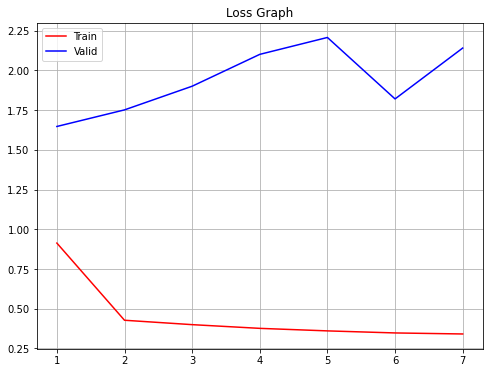


**************************************************



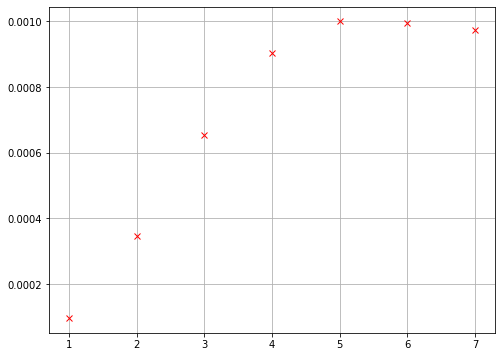


**************************************************



In [7]:
filenames = np.array(os.listdir(os.path.join(cfg.tr_data_path, "photo")))

for tr_idx, va_idx in KFold(n_splits=cfg.n_splits, random_state=cfg.seed, shuffle=True).split(filenames):
    break

tr_filenames, va_filenames = filenames[tr_idx], filenames[va_idx]

tr_data_setup = DS(cfg.tr_data_path, tr_filenames, cfg.transform, cfg.transform)
va_data_setup = DS(cfg.tr_data_path, va_filenames, cfg.plain_transform, cfg.plain_transform)

dataloaders = {
    "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
    "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False)
}

cfg = CFG(seed=SEED, epochs=25, early_stopping=5, lr=1e-3, wd=0.0, steps_per_epoch=len(dataloaders["train"]))

torch.manual_seed(cfg.seed)
model = Model().to(cfg.device)
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
                                          max_lr=cfg.max_lr, 
                                          epochs=cfg.epochs, 
                                          steps_per_epoch=cfg.steps_per_epoch,
                                          pct_start=cfg.pct_start, 
                                          div_factor=cfg.div_factor, 
                                          final_div_factor=cfg.final_div_factor)

L, LR, BLE, name = fit(model=model, 
                       optimizer=optimizer, 
                       scheduler_oclr=scheduler, 
                       epochs=cfg.epochs, 
                       early_stopping_patience=cfg.early_stopping, 
                       dataloaders=dataloaders, 
                       device=cfg.device,
                       save_path=cfg.save_path,
                       verbose=True)

breaker()
show_loss_graph(L)
breaker()
if len(LR) > 0: show_lr_graph(LR)
breaker()

### **Test**


**************************************************

Test Sample 1786

**************************************************



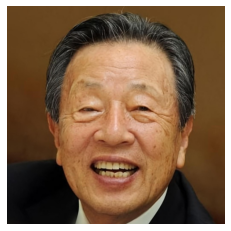

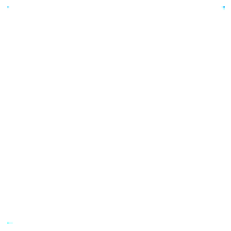


**************************************************



In [8]:
ts_filenames = os.listdir(os.path.join(cfg.ts_data_path, "photo"))

index = r.randint(0, len(ts_filenames))

image = cv2.cvtColor(src=cv2.imread(os.path.join(os.path.join(cfg.ts_data_path, "photo"), ts_filenames[index])), code=cv2.COLOR_BGR2RGB)

decoded_image = predict(model, cfg.device, image, SIZE, "saves/state.pt")

breaker()
print(f"Test Sample {index}")
breaker()
show(image)
print("")
show(decoded_image)
breaker()